In [1]:
import irradiance_beds
import pandas as pd
import xarray as xr

In [2]:
### Alternatively we can run the function on this file rather than pulling from dataset netcdfs

loaded = pd.read_csv(r"agrivoltaics_irradiance_single_location-time-index.csv", index_col=0)
loaded.index = pd.DatetimeIndex(loaded.index)

In [45]:
for conf in ["01", "02", "03"]:
    for i in range(1,3):

        fp = f"/projects/inspire/PySAM-MAPS/CO-sample/{conf}/1-16th-res-{conf}.nc"

        irradiance_da = single_location_irrradiance_df = geospatial_loaded_co.isel(latitude=0, longitude=i).ground_irradiance
        latitude = irradiance_da.latitude.values
        longitude = irradiance_da.longitude.values
        
        single_location_irrradiance_df = geospatial_loaded_co.isel(latitude=0, longitude=i).ground_irradiance.to_pandas()

        conf_beds = irradiance_beds.testbeds_irradiance(
            irradiance_df=single_location_irrradiance_df,
            conf=conf
        )

        res = pd.concat([single_location_irrradiance_df, conf_beds], axis=1)

        res.to_csv(f"beds-irradiance-{latitude}-{longitude}-conf-{conf}.csv")

In [126]:
### CONVERTING TO H5 from csvs
# this is a bad step, we do not want to do this on a large scale but CSV's existed already ehhh

import os
import glob
import xarray as xr

files = glob.glob(os.path.join(os.getcwd(), "beds-*.csv"))

In [125]:
files

['/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-01.csv',
 '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-02.csv',
 '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-03.csv']

In [129]:
from collections import defaultdict
# Group by configuration type (conf-01, conf-02, conf-03)
config_groups = defaultdict(list)

for file in files:
    # Extract configuration type from the filename
    parts = file.split("-")
    config_type = parts[-1].split(".")[0]  # Extract conf-01, conf-02, conf-03
    config_groups[config_type].append(file)

    
# Display the grouped results
for config, paths in sorted(config_groups.items()):
    print(f"{config} group has {len(paths)} locations:")
    for path in paths:
        print(f"  - {path}")
    print()

01 group has 2 locations:
  - /home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-01.csv
  - /home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.73999786376953-conf-01.csv

02 group has 2 locations:
  - /home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.73999786376953-conf-02.csv
  - /home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-02.csv

03 group has 2 locations:
  - /home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.73999786376953-conf-03.csv
  - /home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-03.csv



In [131]:
config_groups

defaultdict(list,
            {'03': ['/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.73999786376953-conf-03.csv',
              '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-03.csv'],
             '01': ['/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-01.csv',
              '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.73999786376953-conf-01.csv'],
             '02': ['/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.73999786376953-conf-02.csv',
              '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-02.csv']})

In [132]:
for conf in ['01','02','03']:
    path_a = config_groups[conf][0]
    path_a = config_groups[conf][1]

    single = load_csv(path_a)

    # only contains first location for now
    builder = xr.Dataset.from_dataframe(single).expand_dims({"latitude":lats, "longitude":lons})
    
    second_location = xr.Dataset.from_dataframe(load_csv(path_b))
    
    builder = builder.assign({
        var: builder[var].where(~((builder.latitude == lats[0]) & (builder.longitude == lons[1])), second_location[var])
        for var in second_location.data_vars
    })

    builder.to_netcdf(f"{conf}-irradiance.h5", engine="h5netcdf")

    

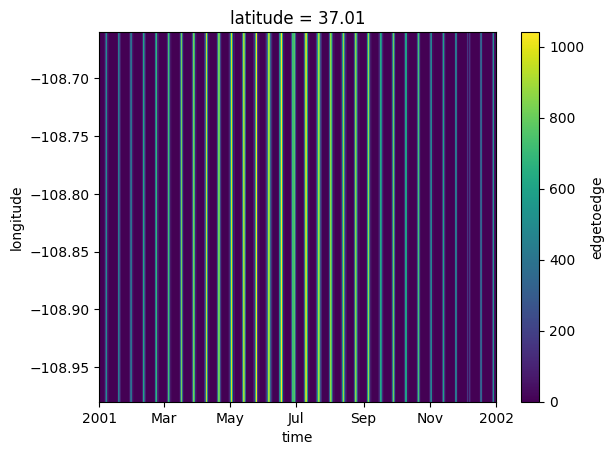

In [136]:
xr.open_dataset("03-irradiance.h5").edgetoedge.plot()

In [119]:
files = groups['--108.73999786376953']
files = groups['--108.9000015258789']

# handle configs in order
files.sort()

path_a = files[0]
path_b = files[1]

def load_csv(path) -> xr.Dataset:

    single = pd.read_csv(path, index_col=0)
    single.index = pd.date_range("2001-01-01 00:30:00", periods=8760, freq="1h")
    single.index.name = "time"

    return single

single = load_csv(path_a)
single

['/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-01.csv', '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-02.csv', '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/irradiance_beds/beds-irradiance-37.0099983215332--108.9000015258789-conf-03.csv']


,0,1,2,3,4,5,6,7,8,9,underpanel,edgetoedge,bedA,bedB,bedC
time,,,,,,,,,,,,,,,
2001-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 02:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 03:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-01 04:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-12-31 19:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-12-31 20:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-12-31 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
lats = [
37.0099983215332
]
    
lons = [
-108.73999786376953,
-108.9000015258789
]

# only contains first location for now
builder = xr.Dataset.from_dataframe(single).expand_dims({"latitude":lats, "longitude":lons})

second_location = xr.Dataset.from_dataframe(load_csv(path_b))

builder = builder.assign({
    var: builder[var].where(~((builder.latitude == lats[0]) & (builder.longitude == lons[1])), second_location[var])
    for var in second_location.data_vars
})

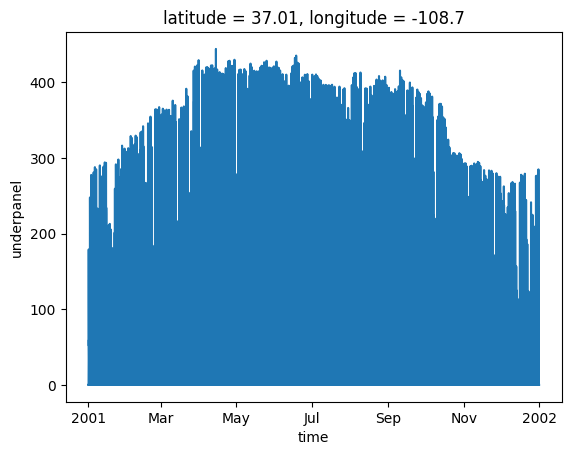

In [109]:
builder.isel(latitude=0, longitude=0)